In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [2]:
df = pd.read_csv("products.csv")
print("Available columns:", df.columns.tolist())
print(df.head())
print(df.info())

Available columns: ['TransactionID', 'CustomerID', 'Products', 'Timestamp']
   TransactionID CustomerID  \
0              1       C546   
1              2       C385   
2              3       C292   
3              4       C863   
4              5       C171   

                                            Products   Timestamp  
0  Dish Sponge, Flatbread with Meat, Chips, Orang...  2025-02-18  
1         Onion, Juice, Flatbread with Meat, Chicken  2025-04-26  
2            Egg, Flatbread with Meat, Banana, Pizza  2025-04-25  
3  Ice Cream, Soda, Orange, Potato, Cereal, Choco...  2025-01-14  
4  Ice Cream, Soap, Shampoo, Chicken, Banana, Bea...  2025-04-20  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  30000 non-null  int64 
 1   CustomerID     30000 non-null  object
 2   Products       30000 non-null  object
 3   Timesta

In [4]:
df.dropna(inplace=True)
df['Products'] = df['Products'].str.lower().str.replace('[^a-z, ]', '', regex=True)
df['ProductList'] = df['Products'].apply(lambda x: [item.strip() for item in x.split(',')])

In [13]:
df['Products'] = df['Products'].str.lower().str.replace('[^a-z, ]', '', regex=True)
df['ProductList'] = df['Products'].apply(lambda x: [item.strip() for item in x.split(',')])

In [14]:
transactions = df['ProductList'].tolist()
encoder = TransactionEncoder()
encoded_array = encoder.fit_transform(transactions)
encoded_df = pd.DataFrame(encoded_array, columns=encoder.columns_)

frequent_items = apriori(encoded_df, min_support=0.1, use_colnames=True)
print("\n✅ Frequent itemsets (support ≥ 10%):")
print(frequent_items.head())

rules = association_rules(frequent_items, metric="lift", min_threshold=1.0)
important_rules = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
important_rules.sort_values(by='lift', ascending=False, inplace=True)
print("\n🔗 Top Association Rules:")
print(important_rules.head())


✅ Frequent itemsets (support ≥ 10%):
    support  itemsets
0  0.160467   (apple)
1  0.163033  (banana)
2  0.164967   (beans)
3  0.162333   (bread)
4  0.162033  (butter)

🔗 Top Association Rules:
Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []


/tmp/ipython-input-14-4168796933.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  important_rules.sort_values(by='lift', ascending=False, inplace=True)


In [15]:
joined_text = df['ProductList'].apply(lambda x: ' '.join(x))
tfidf_model = TfidfVectorizer(max_features=100)
X = tfidf_model.fit_transform(joined_text).toarray()

In [25]:
silhouette_results = {}
cluster_models = {}
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    cluster_models[k] = kmeans
    silhouette_results[k] = score

best_k = max(silhouette_results, key=silhouette_results.get)
best_model = cluster_models[best_k]
df['cluster'] = best_model.predict(X)

print(f"\n🏆 Best clustering result: k = {best_k} with silhouette score = {silhouette_results[best_k]:.4f}")



🏆 Best clustering result: k = 5 with silhouette score = 0.0627


/tmp/ipython-input-26-1468163307.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='cluster', palette='viridis')


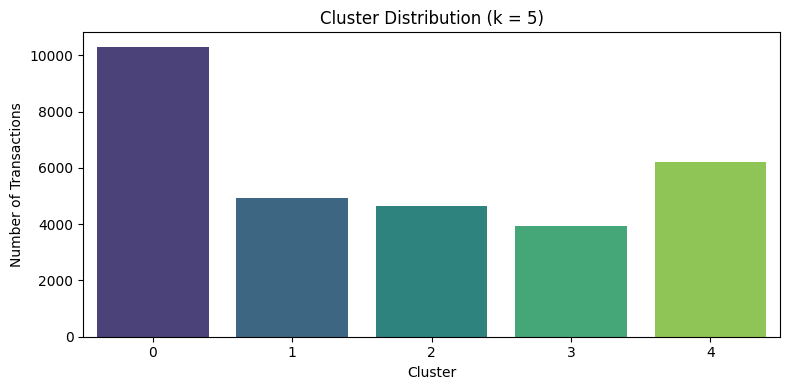

In [26]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='cluster', palette='viridis')
plt.title(f"Cluster Distribution (k = {best_k})")
plt.xlabel("Cluster")
plt.ylabel("Number of Transactions")
plt.tight_layout()
plt.show()

In [27]:
for i in sorted(df['cluster'].unique()):
    print(f"\n📦 Cluster {i} Sample Transactions:")
    print(df[df['cluster'] == i]['Products'].head(3).to_string(index=False))



📦 Cluster 0 Sample Transactions:
                   soda, rice, soap, chickpeas
           sausage, strawberry, cracker, pizza
potato, chicken, cucumber, soda, butter, juice

📦 Cluster 1 Sample Transactions:
dish sponge, flatbread with meat, chips, orange...
ice cream, soda, orange, potato, cereal, chocol...
ice cream, soap, shampoo, chicken, banana, bean...

📦 Cluster 2 Sample Transactions:
cookie, cereal, sausage, chips, chocolate, lent...
milk, minced meat, chips, chicken, onion, chees...
cracker, sausage, dumpling, cookie, detergent, ...

📦 Cluster 3 Sample Transactions:
     dish sponge, onion, detergent, egg, chicken
cereal, minced meat, banana, dish sponge, orange
             yogurt, dish sponge, butter, cookie

📦 Cluster 4 Sample Transactions:
        onion, juice, flatbread with meat, chicken
           egg, flatbread with meat, banana, pizza
juice, shampoo, bread, flatbread with meat, cra...


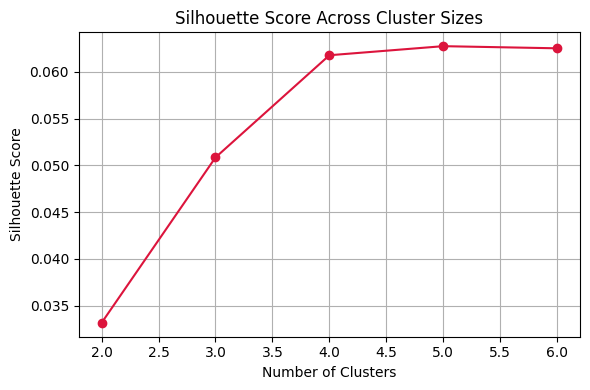

In [28]:
plt.figure(figsize=(6, 4))
plt.plot(list(silhouette_results.keys()), list(silhouette_results.values()), marker='o', color='crimson')
plt.title("Silhouette Score Across Cluster Sizes")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
print("\n📌 Model Performance Summary:")
for k, score in silhouette_results.items():
    print(f"Clusters = {k} → Silhouette Score = {score:.4f}")

print("\n🧠 Best Performing Model:")
print(f"KMeans with {best_k} clusters")

print("\n🔍 Top 5 Association Rules:")
print(important_rules.head())



📌 Model Performance Summary:
Clusters = 2 → Silhouette Score = 0.0332
Clusters = 3 → Silhouette Score = 0.0508
Clusters = 4 → Silhouette Score = 0.0618
Clusters = 5 → Silhouette Score = 0.0627
Clusters = 6 → Silhouette Score = 0.0625

🧠 Best Performing Model:
KMeans with 5 clusters

🔍 Top 5 Association Rules:
Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []
